# Rapid Refresh Model Plotting 

This notebook gives several examples of plotting QG analyses using RAP analyses

In [189]:
#Required Libraries
from datetime import datetime, timedelta

from model_functions import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors

import metpy
from metpy.plots import StationPlot
from metpy.units import units
import metpy.calc as mpcalc

import numpy as np

from netCDF4 import Dataset, num2date

from scipy.ndimage import gaussian_filter

from xarray.backends import NetCDF4DataStore
import xarray as xr

import pandas as pd

In [218]:
#set time to plot (no leading zeros)
start_year  = 2021
start_month = 12
start_day   = 11
start_hour  = 4
start_min   = 0
    
#location to plot
#location = True
location_lat = 37.5
location_lon = -98.5J
#    OR
#analysis bounds
location = False
lat_min = 30
lat_max = 50
lon_min = -115
lon_max = -75

In [219]:
dt = datetime(start_year,start_month,start_day,start_hour)
ncss = get_rap_dataset(dt)
print(ncss)

In [220]:
query = ncss.query()
#query.lonlat_box(north=lat_max,south=lat_min,east=lon_max,west=lon_min)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                    'Relative_humidity_isobaric',
                    'u-component_of_wind_isobaric',
                    'u-component_of_wind_height_above_ground',
                    'v-component_of_wind_isobaric',
                    'v-component_of_wind_height_above_ground',
                    'Temperature_isobaric',
                    'MSLP_MAPS_System_Reduction_msl',
                    'Convective_available_potential_energy_surface',
                    'Convective_inhibition_surface',
                    'Absolute_vorticity_isobaric',
                    'Potential_temperature_height_above_ground')

data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()


### Subset Pressure Levels ###


In [221]:
lon = ds.lon
lat = ds.lat
analysis_time = ds.Temperature_isobaric[0].metpy.time

#Distance between grid points.
dx,dy = mpcalc.lat_lon_grid_deltas(lon,lat)


hght_900 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=900*units.hPa, time=analysis_time)
hght_850 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=850*units.hPa, time=analysis_time)
hght_700 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=700*units.hPa, time=analysis_time)
hght_500 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=500*units.hPa, time=analysis_time)
hght_300 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=300*units.hPa, time=analysis_time)
hght_200 = units('meters') * ds.Geopotential_height_isobaric.metpy.sel(
                            vertical=200*units.hPa, time=analysis_time)

temp_900 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=900*units.hPa, time=analysis_time)
temp_850 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=850*units.hPa, time=analysis_time)
temp_700 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=700*units.hPa, time=analysis_time)
temp_500 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=500*units.hPa, time=analysis_time)
temp_300 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=300*units.hPa, time=analysis_time)
temp_200 = units('degK') * ds.Temperature_isobaric.metpy.sel(
                            vertical=200*units.hPa, time=analysis_time)


u_900 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=900*units.hPa, time=analysis_time)
u_850 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=850*units.hPa, time=analysis_time)
u_700 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=700*units.hPa, time=analysis_time)
u_500 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=500*units.hPa, time=analysis_time)
u_300 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=300*units.hPa, time=analysis_time)
u_200 = units('m/s') * ds['u-component_of_wind_isobaric'].metpy.sel(
                            vertical=200*units.hPa, time=analysis_time)

v_900 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=900*units.hPa, time=analysis_time)
v_850 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=850*units.hPa, time=analysis_time)
v_700 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=700*units.hPa, time=analysis_time)
v_500 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=500*units.hPa, time=analysis_time)
v_300 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=300*units.hPa, time=analysis_time)
v_200 = units('m/s') * ds['v-component_of_wind_isobaric'].metpy.sel(
                            vertical=200*units.hPa, time=analysis_time)

### QG Omega ###

QG Omega equation form Bluestein *Synoptic-Dynamic Meteorology in Midlatitudes Volume I* (1992; Eq. 5.6.14) ignoring diabatic heating and friction.

$$
 (\nabla^2_p + \frac{f^2_0}{\sigma}\frac{\partial^2}{\partial p^2})\omega = - \frac{f_0}{\sigma} \frac{\partial}{\partial p} [-v_g \cdot \nabla_p (\zeta_g + f)] - \frac{R}{\sigma p}\nabla^2_p(-v_g\cdot\nabla_p T)
$$

This can be solved with the data we've already imported.


In [222]:
#constants:
#sigma isn't a constant, but we'll treat it as such for simplicity
sigma = (2.0E-6 * units('m^2 Pa^-2 s^-2')).to_base_units()

#assume f0 is sufficient (from scale analysis of Beta-Plane Approx)
f0 = 1.0E-4 * units('s^-1')

#assume dry air gas constant (from metpy)
Rd = metpy.constants.Rd


In [223]:
#Smooth variables to remove smaller-than-synoptic-scale features

#Number of repetitions of smoothing function
n_reps = 50

# Apply the 9-point smoother
hght_900s = mpcalc.smooth_n_point(hght_900, 9, n_reps)
hght_850s = mpcalc.smooth_n_point(hght_850, 9, n_reps)
hght_700s = mpcalc.smooth_n_point(hght_700, 9, n_reps)
hght_500s = mpcalc.smooth_n_point(hght_500, 9, n_reps)
hght_300s = mpcalc.smooth_n_point(hght_300, 9, n_reps)
hght_200s = mpcalc.smooth_n_point(hght_200, 9, n_reps)

temp_900s = mpcalc.smooth_n_point(temp_900, 9, n_reps)
temp_850s = mpcalc.smooth_n_point(temp_850, 9, n_reps)
temp_700s = mpcalc.smooth_n_point(temp_700, 9, n_reps)
temp_500s = mpcalc.smooth_n_point(temp_500, 9, n_reps)
temp_300s = mpcalc.smooth_n_point(temp_300, 9, n_reps)
temp_200s = mpcalc.smooth_n_point(temp_200, 9, n_reps)

u_900s = mpcalc.smooth_n_point(u_900, 9, n_reps)
u_850s = mpcalc.smooth_n_point(u_850, 9, n_reps)
u_700s = mpcalc.smooth_n_point(u_700, 9, n_reps)
u_500s = mpcalc.smooth_n_point(u_500, 9, n_reps)
u_300s = mpcalc.smooth_n_point(u_300, 9, n_reps)
u_200s = mpcalc.smooth_n_point(u_200, 9, n_reps)

v_900s = mpcalc.smooth_n_point(v_900, 9, n_reps)
v_850s = mpcalc.smooth_n_point(v_850, 9, n_reps)
v_700s = mpcalc.smooth_n_point(v_700, 9, n_reps)
v_500s = mpcalc.smooth_n_point(v_500, 9, n_reps)
v_300s = mpcalc.smooth_n_point(v_300, 9, n_reps)
v_200s = mpcalc.smooth_n_point(v_200, 9, n_reps)

#### Differential Vorticity Advection Term ####
$$
 - \frac{f_0}{\sigma} \frac{\partial}{\partial p} [-v_g \cdot \nabla_p (\zeta_g + f)]
$$


In [224]:
#calculate absolute vorticity at each level
abs_vor_900 = mpcalc.absolute_vorticity(u_900s,v_900s)
abs_vor_850 = mpcalc.absolute_vorticity(u_850s,v_850s)
abs_vor_700 = mpcalc.absolute_vorticity(u_700s,v_700s)
abs_vor_500 = mpcalc.absolute_vorticity(u_500s,v_500s)
abs_vor_300 = mpcalc.absolute_vorticity(u_300s,v_300s)
abs_vor_200 = mpcalc.absolute_vorticity(u_200s,v_200s)

/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:

In [225]:
#calculate absolute vorticity advection
vort_adv_900 = mpcalc.advection(abs_vor_900,u_900s,v_900s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())
vort_adv_850 = mpcalc.advection(abs_vor_850,u_850s,v_850s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())
vort_adv_700 = mpcalc.advection(abs_vor_700,u_700s,v_700s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())
vort_adv_500 = mpcalc.advection(abs_vor_500,u_500s,v_500s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())
vort_adv_300 = mpcalc.advection(abs_vor_300,u_300s,v_300s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())
vort_adv_200 = mpcalc.advection(abs_vor_200,u_200s,v_200s,latitude=lat,longitude=lon,crs=ccrs.PlateCarree())

/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/

In [226]:
#calculate differential vorticity advection for 850-, 700-, 500-, and 300-hPa
dva_850 = (vort_adv_700 - vort_adv_900)/((200.0 * units.hPa).to_base_units())
dva_700 = (vort_adv_500 - vort_adv_850)/((350.0 * units.hPa).to_base_units())
dva_500 = (vort_adv_300 - vort_adv_700)/((400.0 * units.hPa).to_base_units())
dva_300 = (vort_adv_200 - vort_adv_500)/((300.0 * units.hPa).to_base_units())

#multiply by coriolis/static static stability to get the whole term
dva_term_850 = dva_850
dva_term_700 = dva_700
dva_term_500 = dva_500
dva_term_300 = dva_300

print(dva_term_300)

<xarray.DataArray (y: 337, x: 451)>
<Quantity([[ 3.80742272e-13  4.77778078e-13  1.66512432e-13 ...  2.82114926e-14
  -6.60619318e-14 -1.86369413e-13]
 [ 3.32410188e-13  2.94853059e-13  1.09216191e-13 ...  8.38235215e-14
   9.96454607e-14  6.08236871e-14]
 [-1.98870652e-14  3.99446778e-15  2.31720137e-14 ...  8.70129632e-14
   8.29936490e-14  5.82740093e-14]
 ...
 [-4.28423161e-13 -4.51112418e-14  2.23124331e-13 ...  3.93830708e-13
   3.50340110e-13  2.53285271e-13]
 [-6.25721612e-13 -1.43149029e-13  2.87462920e-14 ...  5.77440078e-13
   5.62564953e-13  8.28939651e-13]
 [ 1.42531381e-12  1.03681476e-12  2.94089267e-13 ...  8.51418778e-13
   4.22530300e-13  5.44773192e-13]], 'meter / kilogram')>
Coordinates:
    time       datetime64[ns] 2021-12-11T04:00:00
  * y          (y) float32 -5.889e+05 -5.753e+05 ... 3.949e+06 3.962e+06
  * x          (x) float32 -3.332e+06 -3.319e+06 ... 2.75e+06 2.763e+06
    metpy_crs  object Projection: lambert_conformal_conic


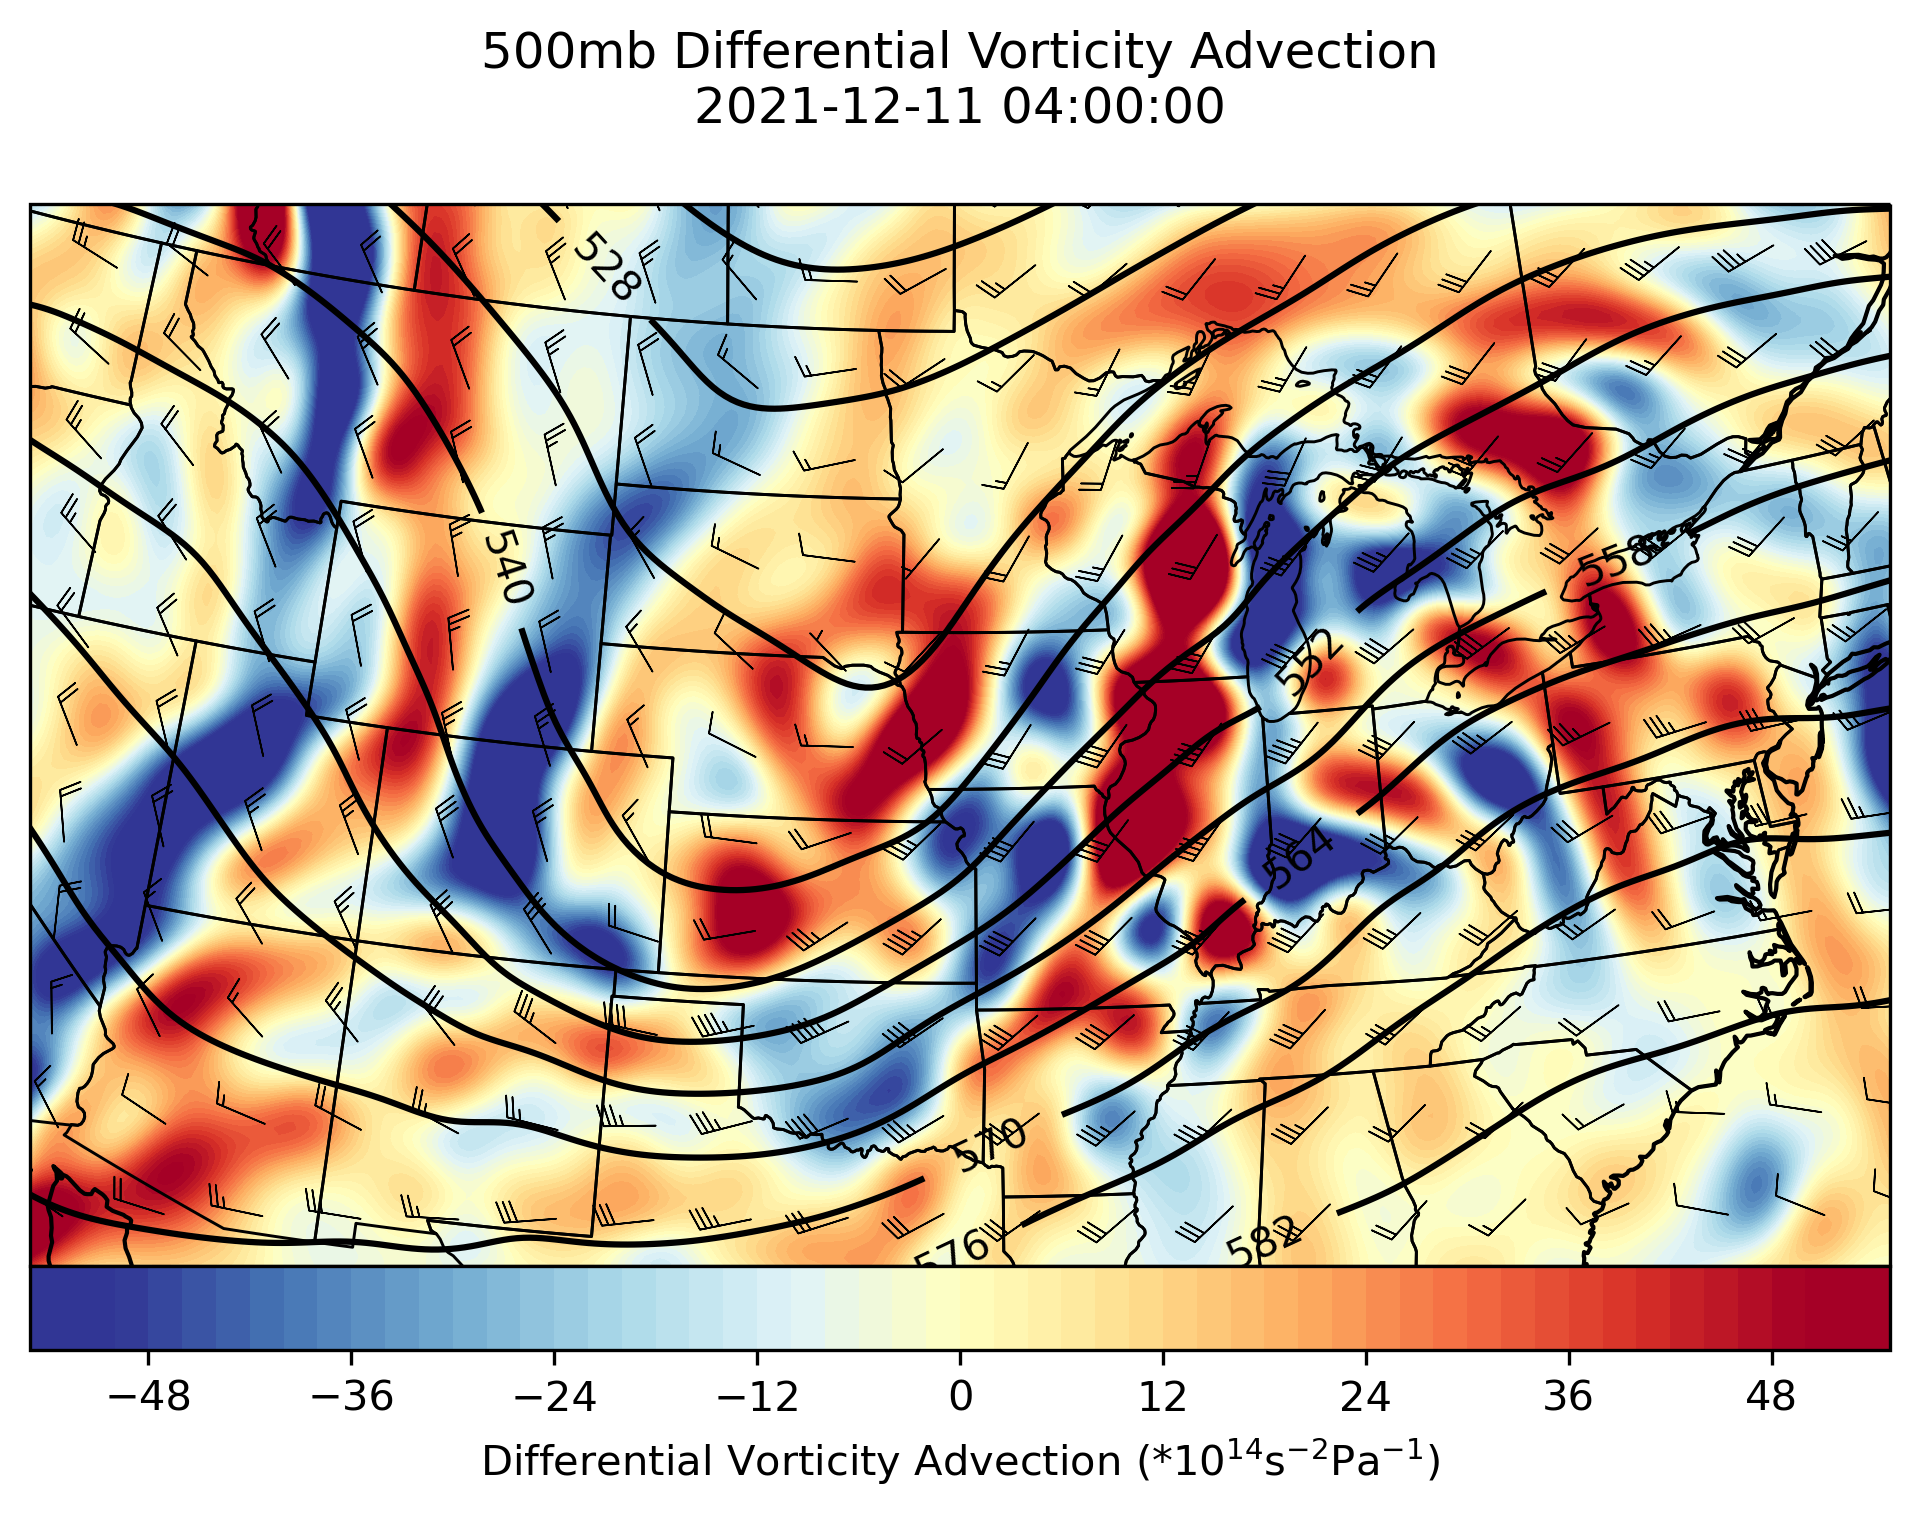

In [227]:
#500mb DVA Chart
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])


fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cs = ax.contour(ds.lon,ds.lat,hght_500s,np.arange(0,8000,60),
                colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10,
             fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)


cf = ax.contourf(ds.lon,ds.lat,dva_term_500*1E14,np.arange(-50,51,2),cmap='RdYlBu_r',extend='both',
                         transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf,orientation='horizontal',pad=0.0,extendrect=True)
cbar.set_label(r'Differential Vorticity Advection ($\rm{*10^{14} s^{-2} Pa^{-1}}$)')


wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_500s[wind_slice].values,
            v_500s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

plt.title(f'500mb Differential Vorticity Advection\n{dt}\n')
plt.savefig(f'500mb_dva_{dt}.png',bbox_inches='tight')


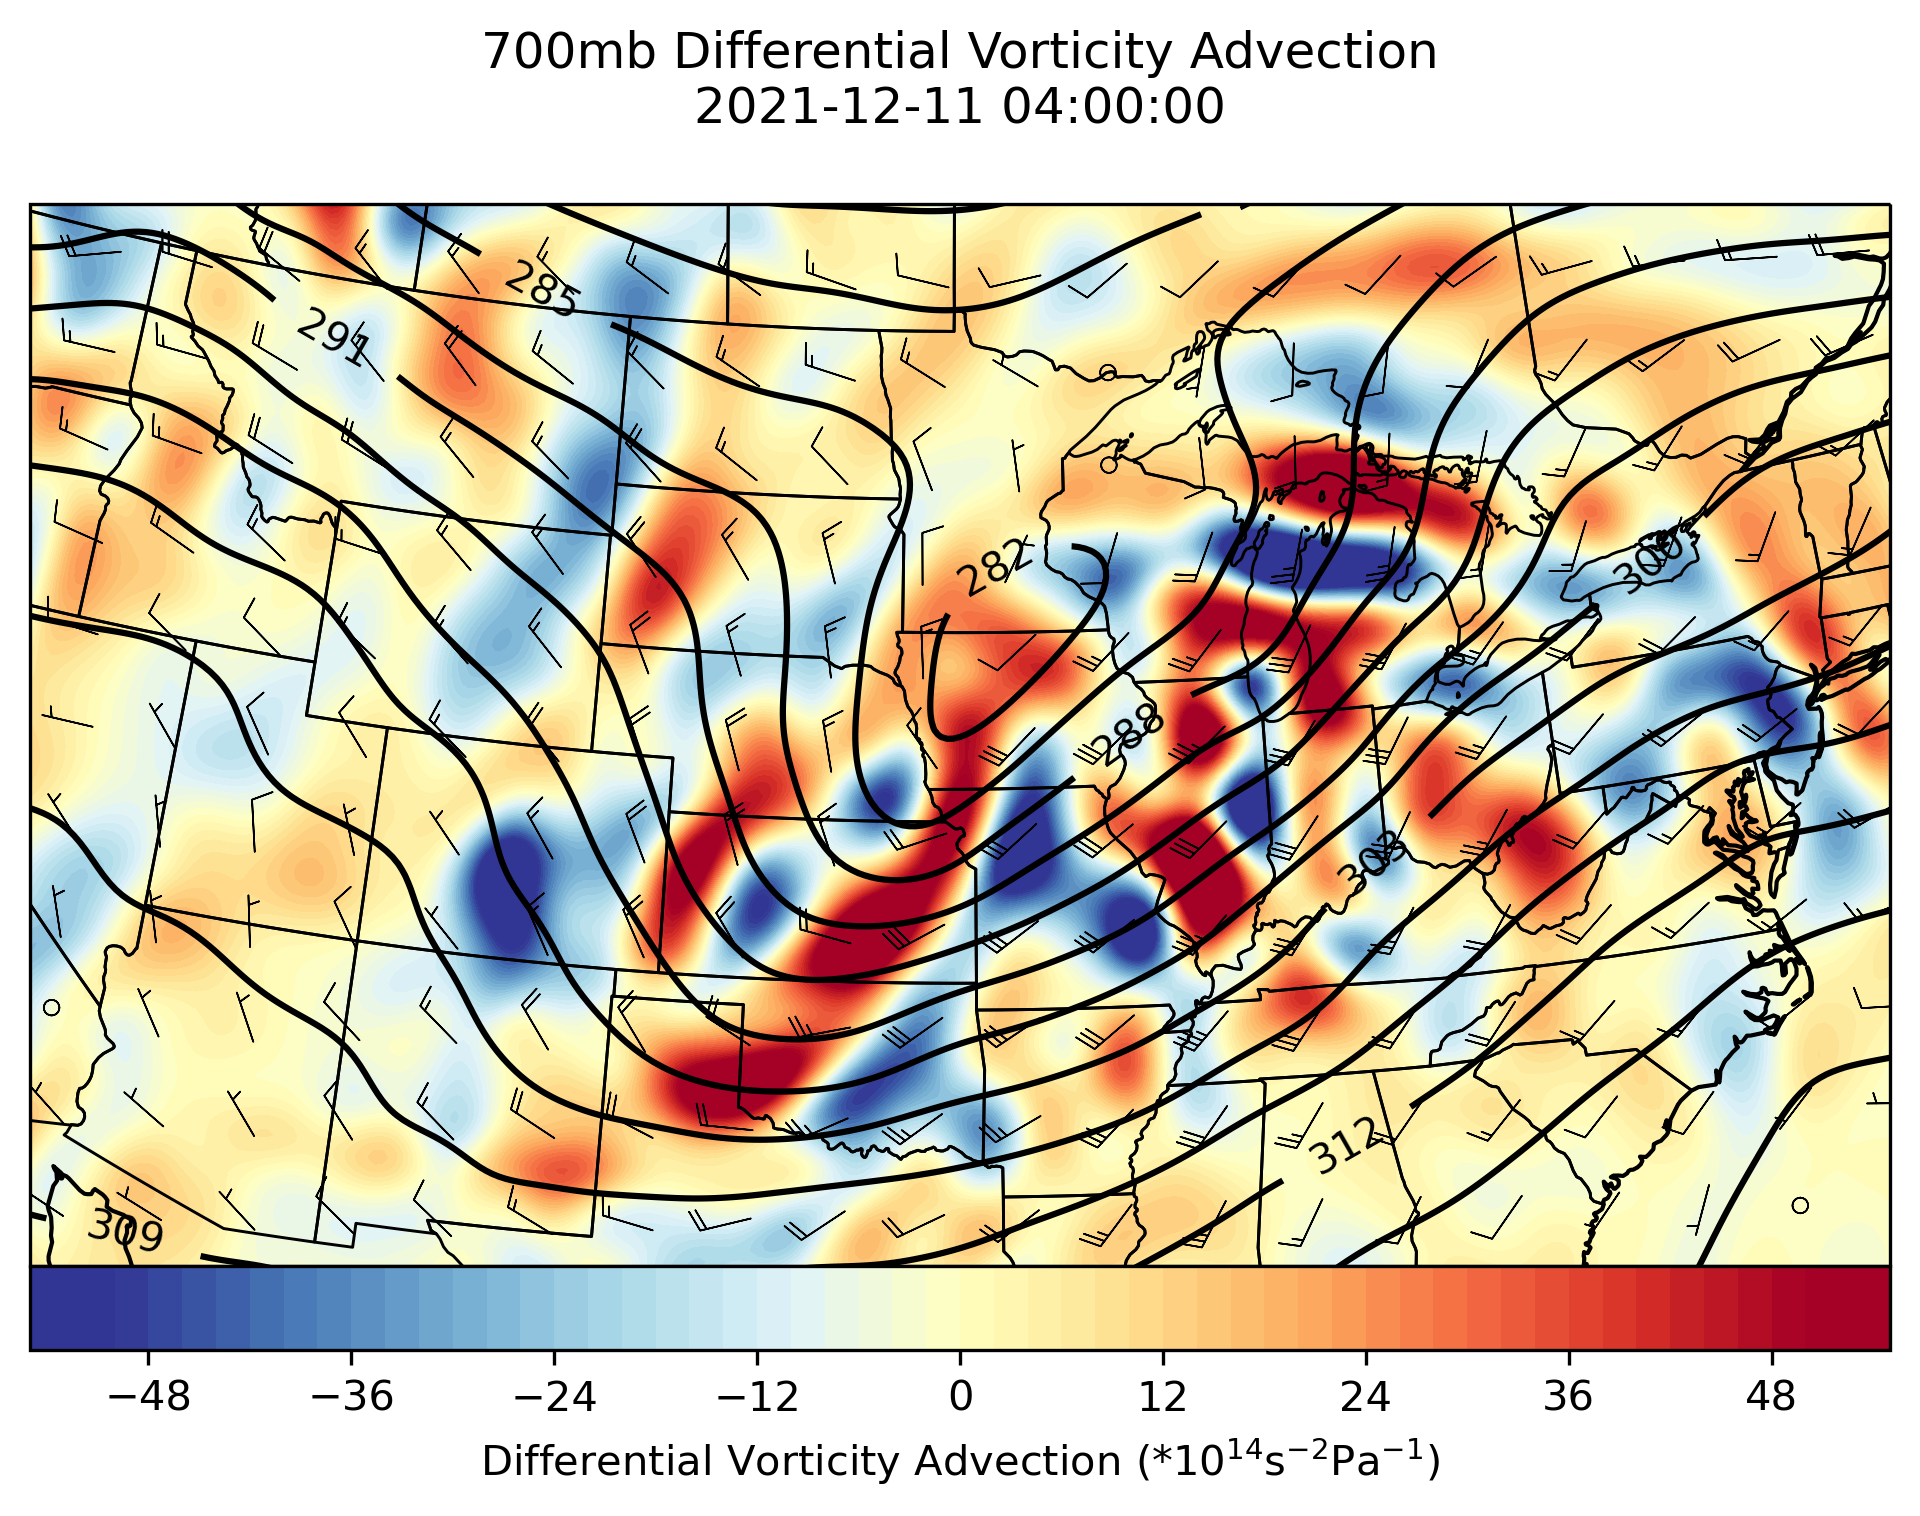

In [228]:
#700mb DVA Chart
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])


fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cs = ax.contour(ds.lon,ds.lat,hght_700s,np.arange(0,8000,30),
                colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10,
             fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)


cf = ax.contourf(ds.lon,ds.lat,dva_term_700*1E14,np.arange(-50,51,2),cmap='RdYlBu_r',extend='both',
                         transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf,orientation='horizontal',pad=0.0,extendrect=True)
cbar.set_label(r'Differential Vorticity Advection ($\rm{*10^{14} s^{-2} Pa^{-1}}$)')


wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_700s[wind_slice].values,
            v_700s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

plt.title(f'700mb Differential Vorticity Advection\n{dt}\n')
plt.savefig(f'700mb_dva_{dt}.png',bbox_inches='tight')

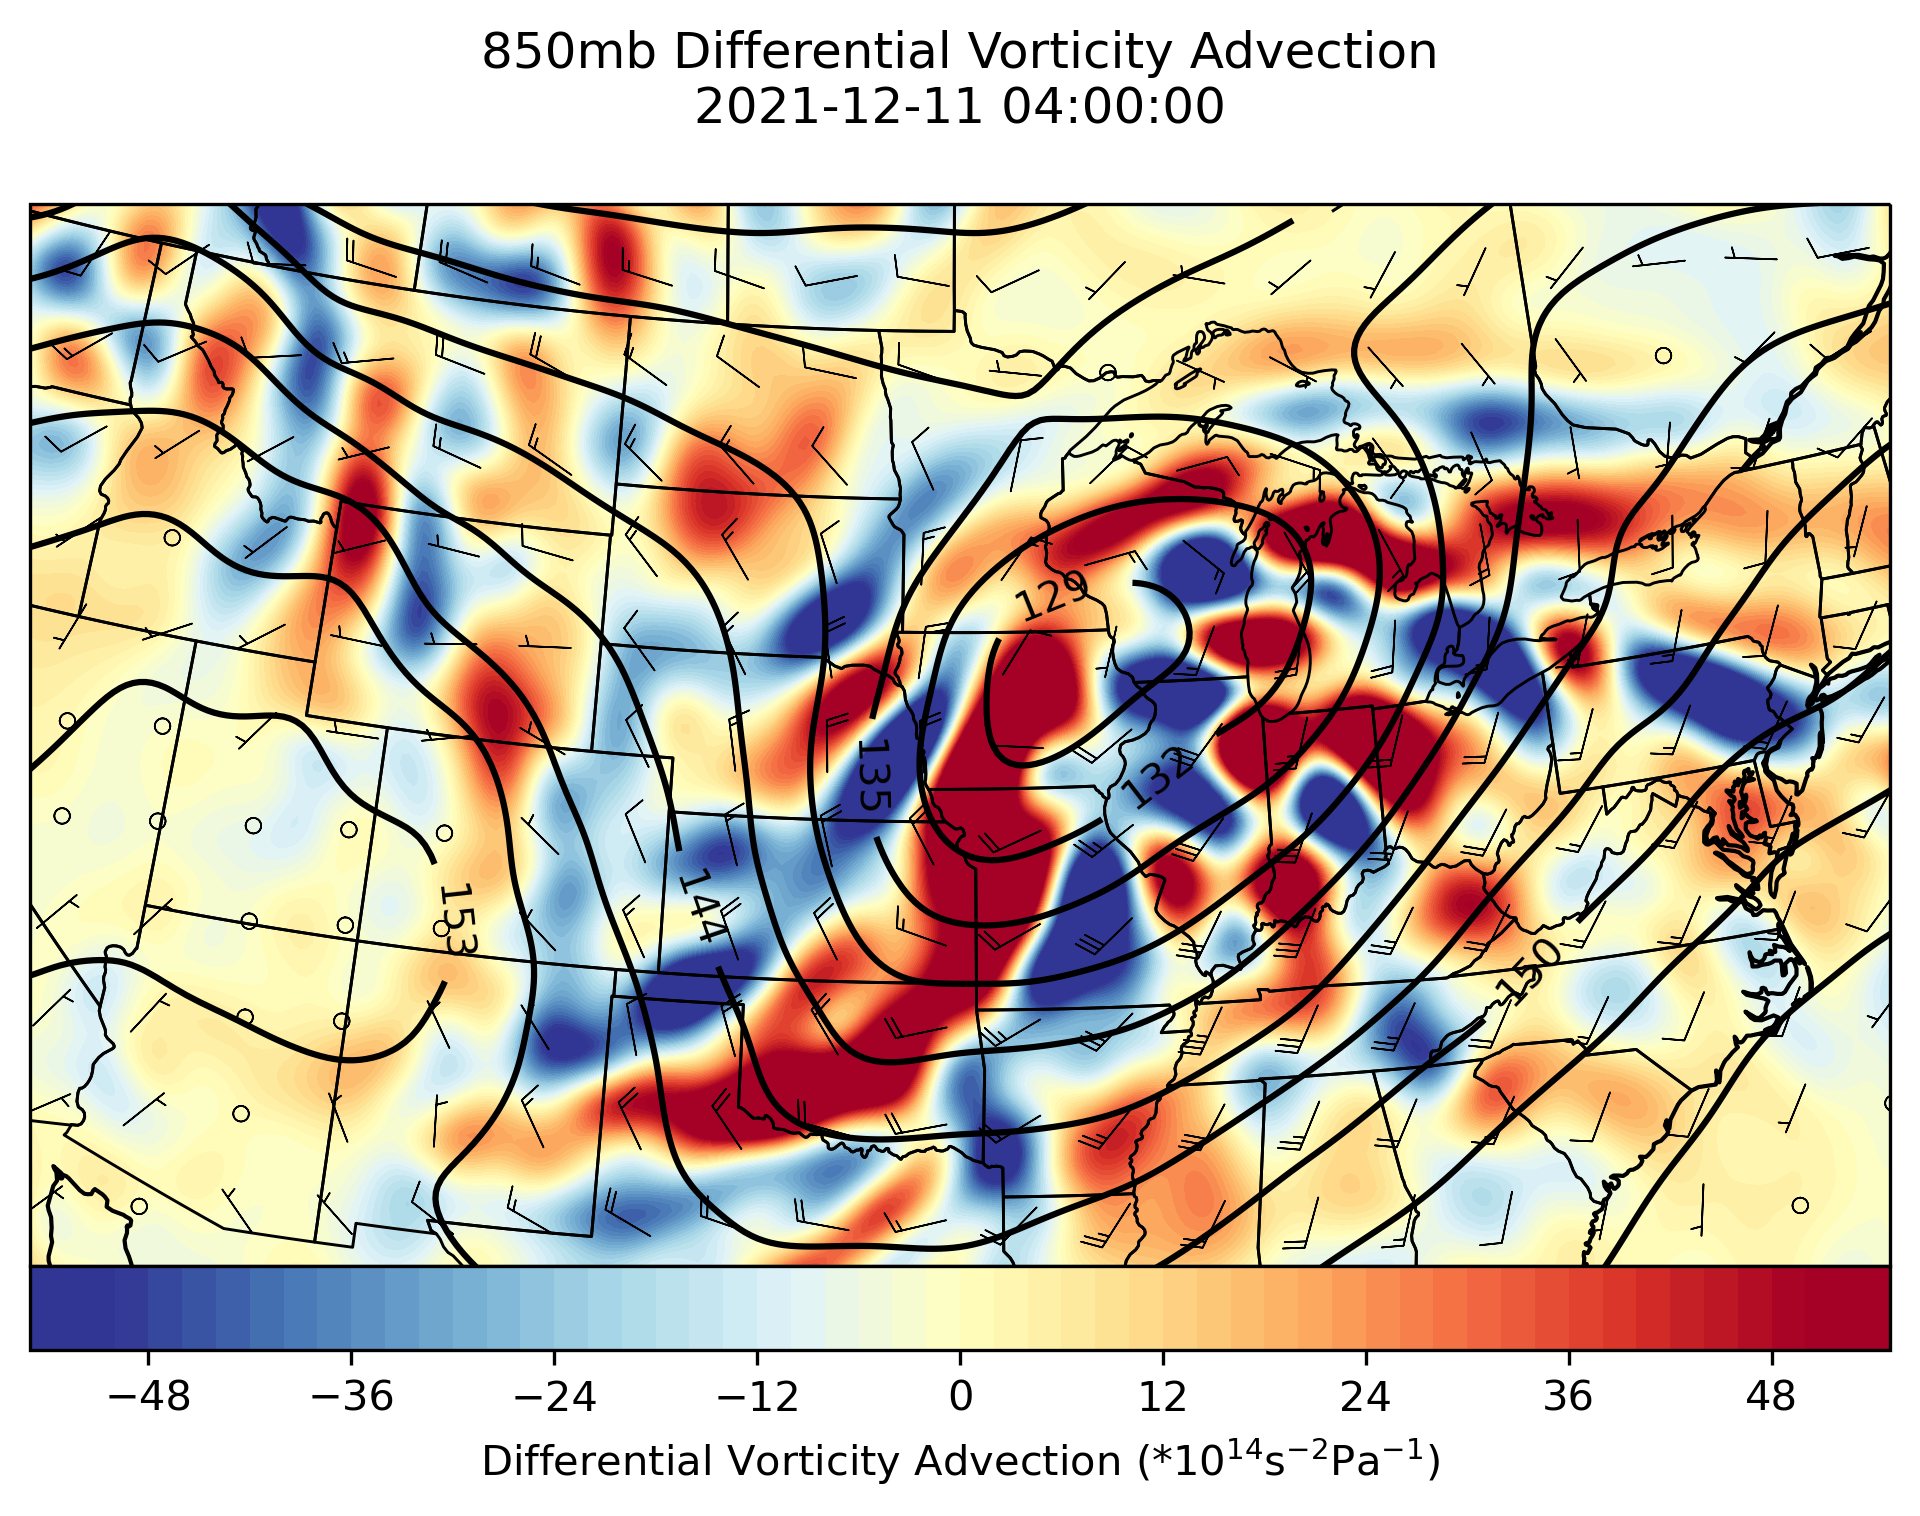

In [229]:
#850mb DVA Chart
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])


fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cs = ax.contour(ds.lon,ds.lat,hght_850s,np.arange(0,8000,30),
                colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10,
             fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)


cf = ax.contourf(ds.lon,ds.lat,dva_term_850*1E14,np.arange(-50,51,2),cmap='RdYlBu_r',extend='both',
                         transform=ccrs.PlateCarree())
cbar = plt.colorbar(cf,orientation='horizontal',pad=0.0,extendrect=True)
cbar.set_label(r'Differential Vorticity Advection ($\rm{*10^{14} s^{-2} Pa^{-1}}$)')


wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_850s[wind_slice].values,
            v_850s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

plt.title(f'850mb Differential Vorticity Advection\n{dt}\n')
plt.savefig(f'850mb_dva_{dt}.png',bbox_inches='tight')

In [230]:
tadv_500 = mpcalc.advection(temp_500,u_500s,v_500s,
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())
tadv_700 = mpcalc.advection(temp_700s,u_700s,v_700s,
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())
tadv_850 = mpcalc.advection(temp_850,u_850,v_850,
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())
tadv_850 = gaussian_filter(tadv_850,sigma=3,order=0)*units('K/sec')
print(tadv_850.to(units('delta_degC/hour')))


/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/

[[0.009410866536200047 0.010989682748913765 0.0132053317502141 ...  0.09024160355329514 0.0881798192858696 0.08608709275722504] [0.01364076230674982 0.015003906562924385 0.016816893592476845 ...  0.09850885719060898 0.0960245132446289 0.09368542581796646] [0.021389365196228027 0.022429056465625763 0.023633215576410294 ...  0.11141203343868256 0.10798516869544983 0.10510584712028503] ... [-0.3079497814178467 -0.2818407416343689 -0.23519614338874817 ...  0.5428858399391174 0.5452033877372742 0.5439617037773132] [-0.31944116950035095 -0.2924606204032898 -0.2441583126783371 ...  0.5881717801094055 0.5828103423118591 0.5771450996398926] [-0.32555055618286133 -0.2982047498226166 -0.24918271601200104 ...  0.610537588596344 0.6007246375083923 0.5925114154815674]] delta_degree_Celsius / hour


/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(


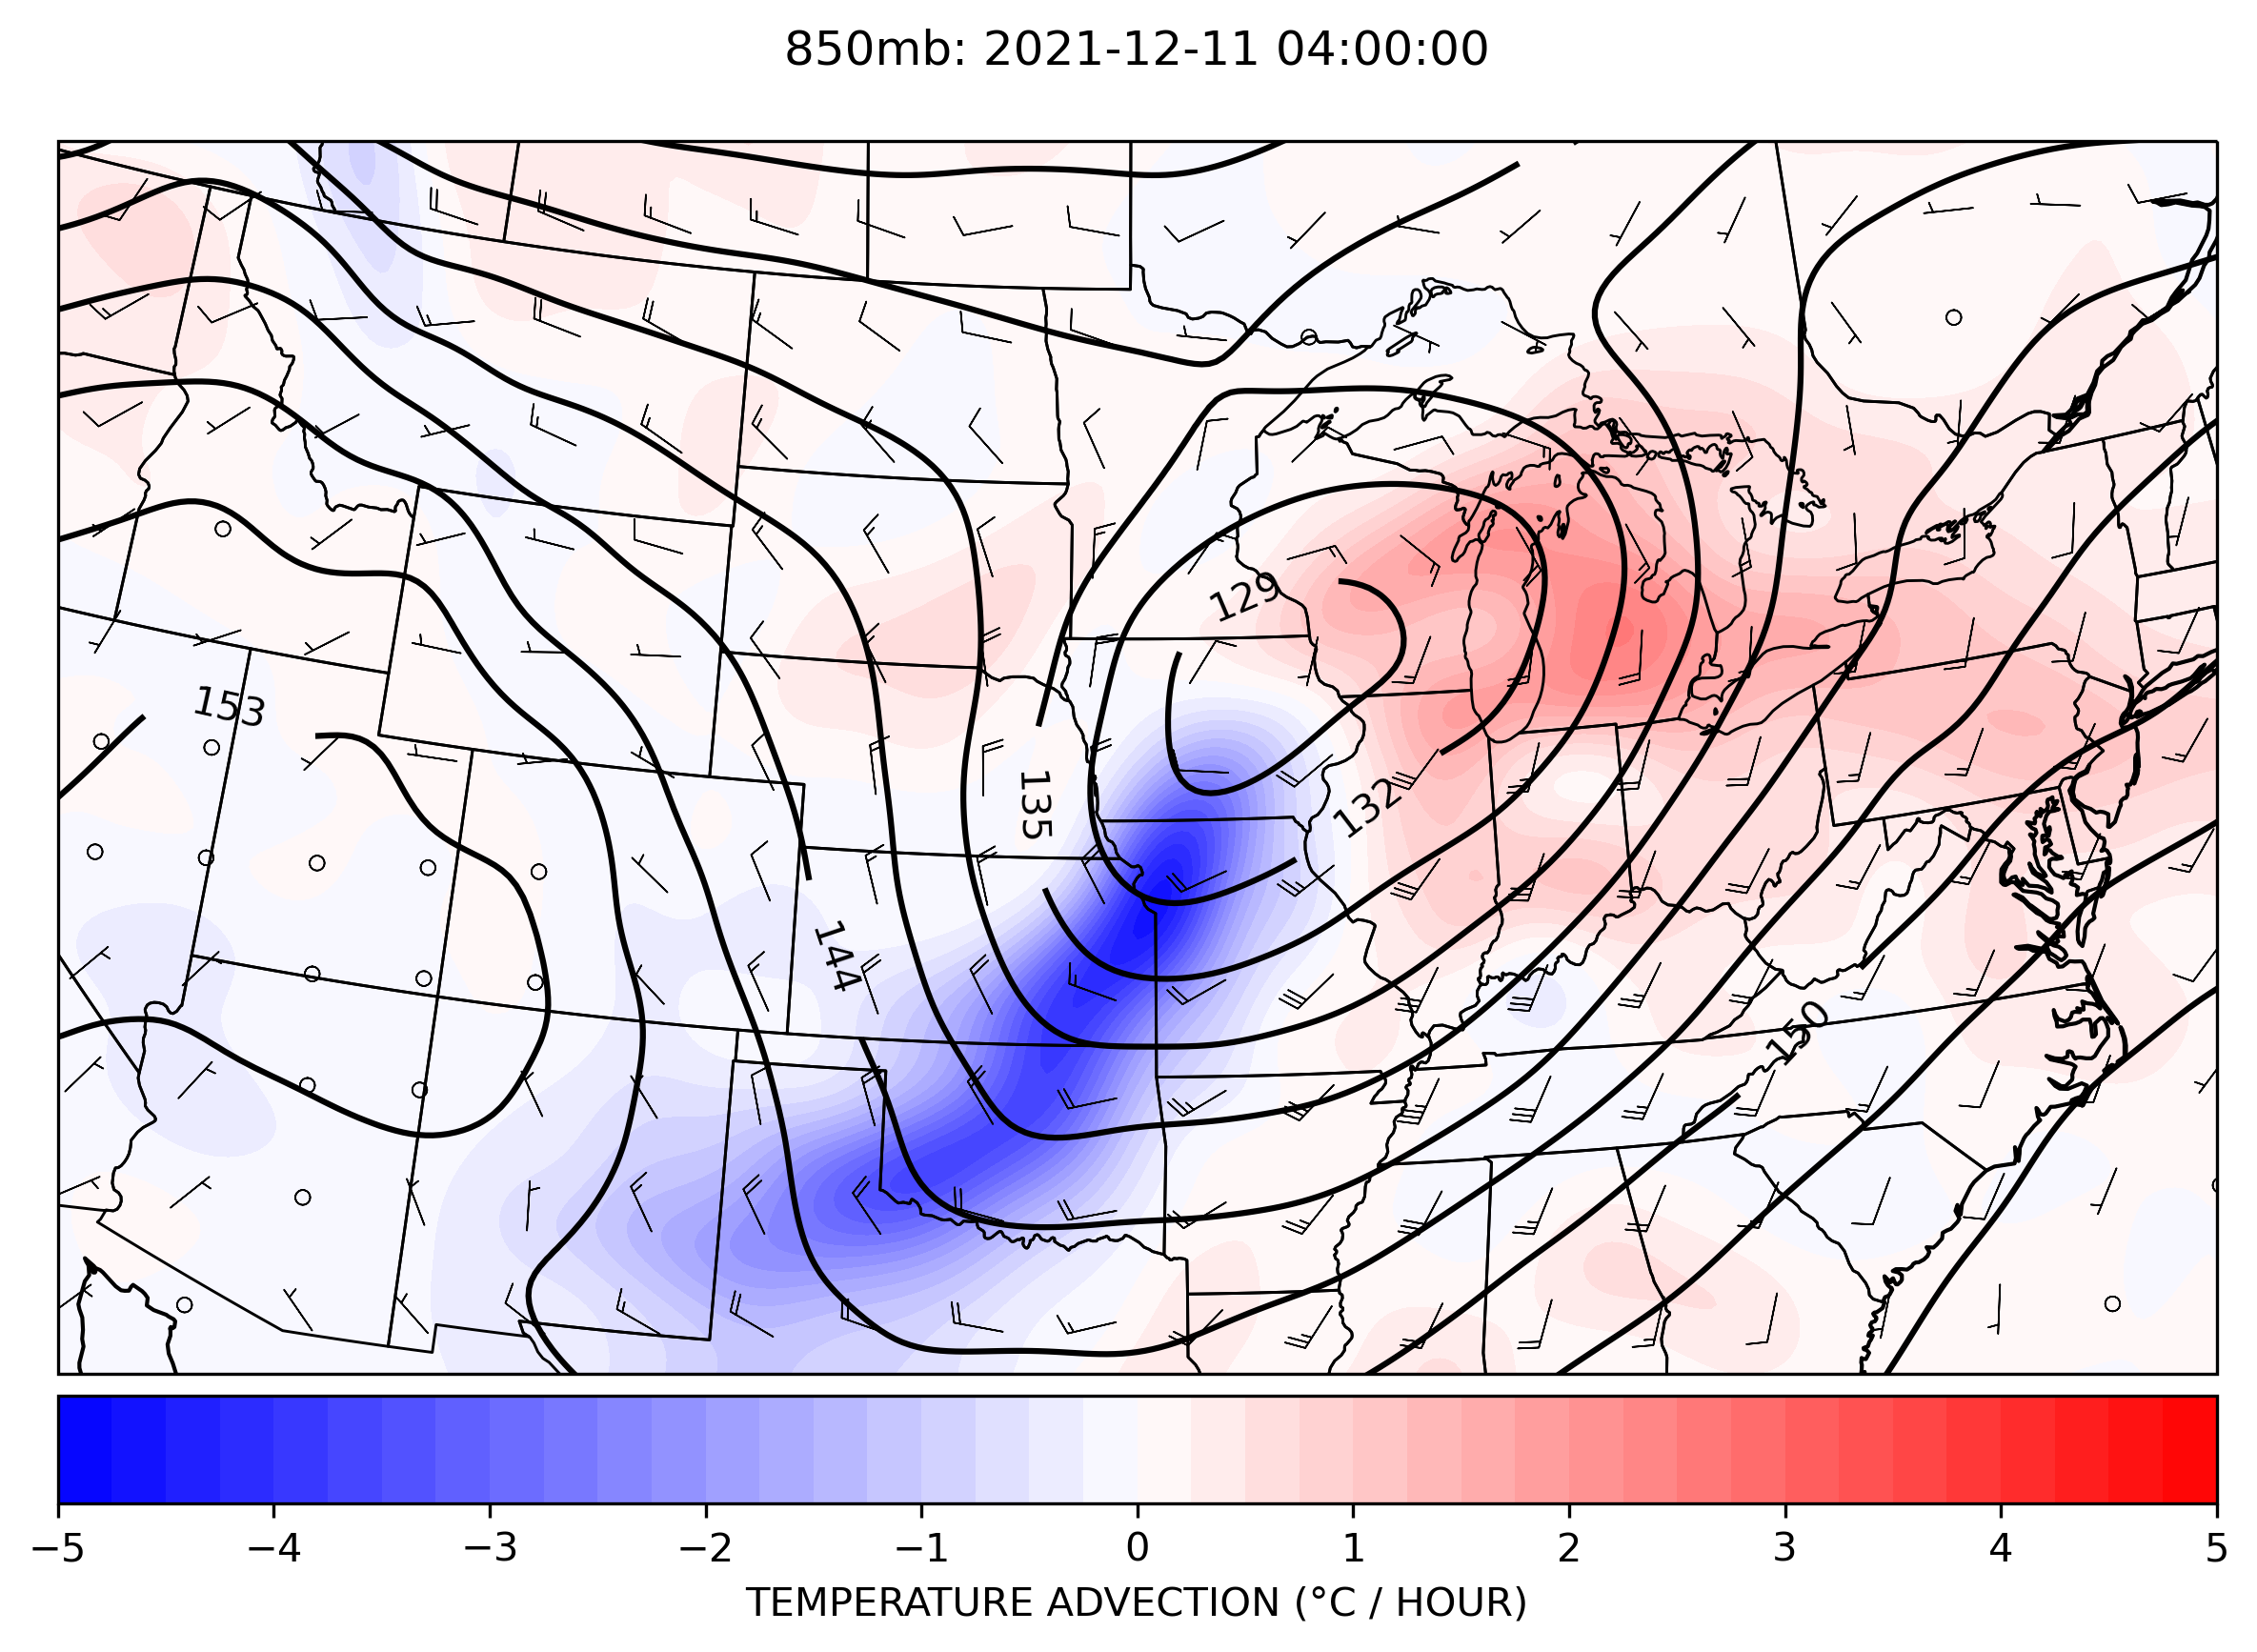

In [231]:
#850mb Temperature Advection

# Calculate temperature advection using metpy function
dx, dy = mpcalc.lat_lon_grid_deltas(ds.lon, ds.lat)
adv = mpcalc.advection(temp_850s, 
                       u_850s,
                       v_850s,
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())

adv = gaussian_filter(adv, sigma=3, order=0) * units('K/sec')

proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cadv = ax.contourf(ds.lon,ds.lat,adv.to(units('delta_degC/hour')),
                   np.arange(-5,5.25,0.25),cmap='bwr',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cadv,location="bottom",ticks=np.arange(-5,6,1),pad=0.01)
cbar.set_label('TEMPERATURE ADVECTION ('+u'\xb0'+'C / HOUR)')


cs = ax.contour(ds.lon,ds.lat,hght_850s,
                   np.arange(0,8000,30),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_850s[wind_slice].values,
            v_850s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())



ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'850mb: {dt}\n')
plt.savefig(f'850mb_tadv_{dt}.png',bbox_inches='tight')

In [232]:
#Divergence
div_500 = mpcalc.divergence(u_500s,v_500s,latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())
div_700 = mpcalc.divergence(u_700s,v_700s,latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())

/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(


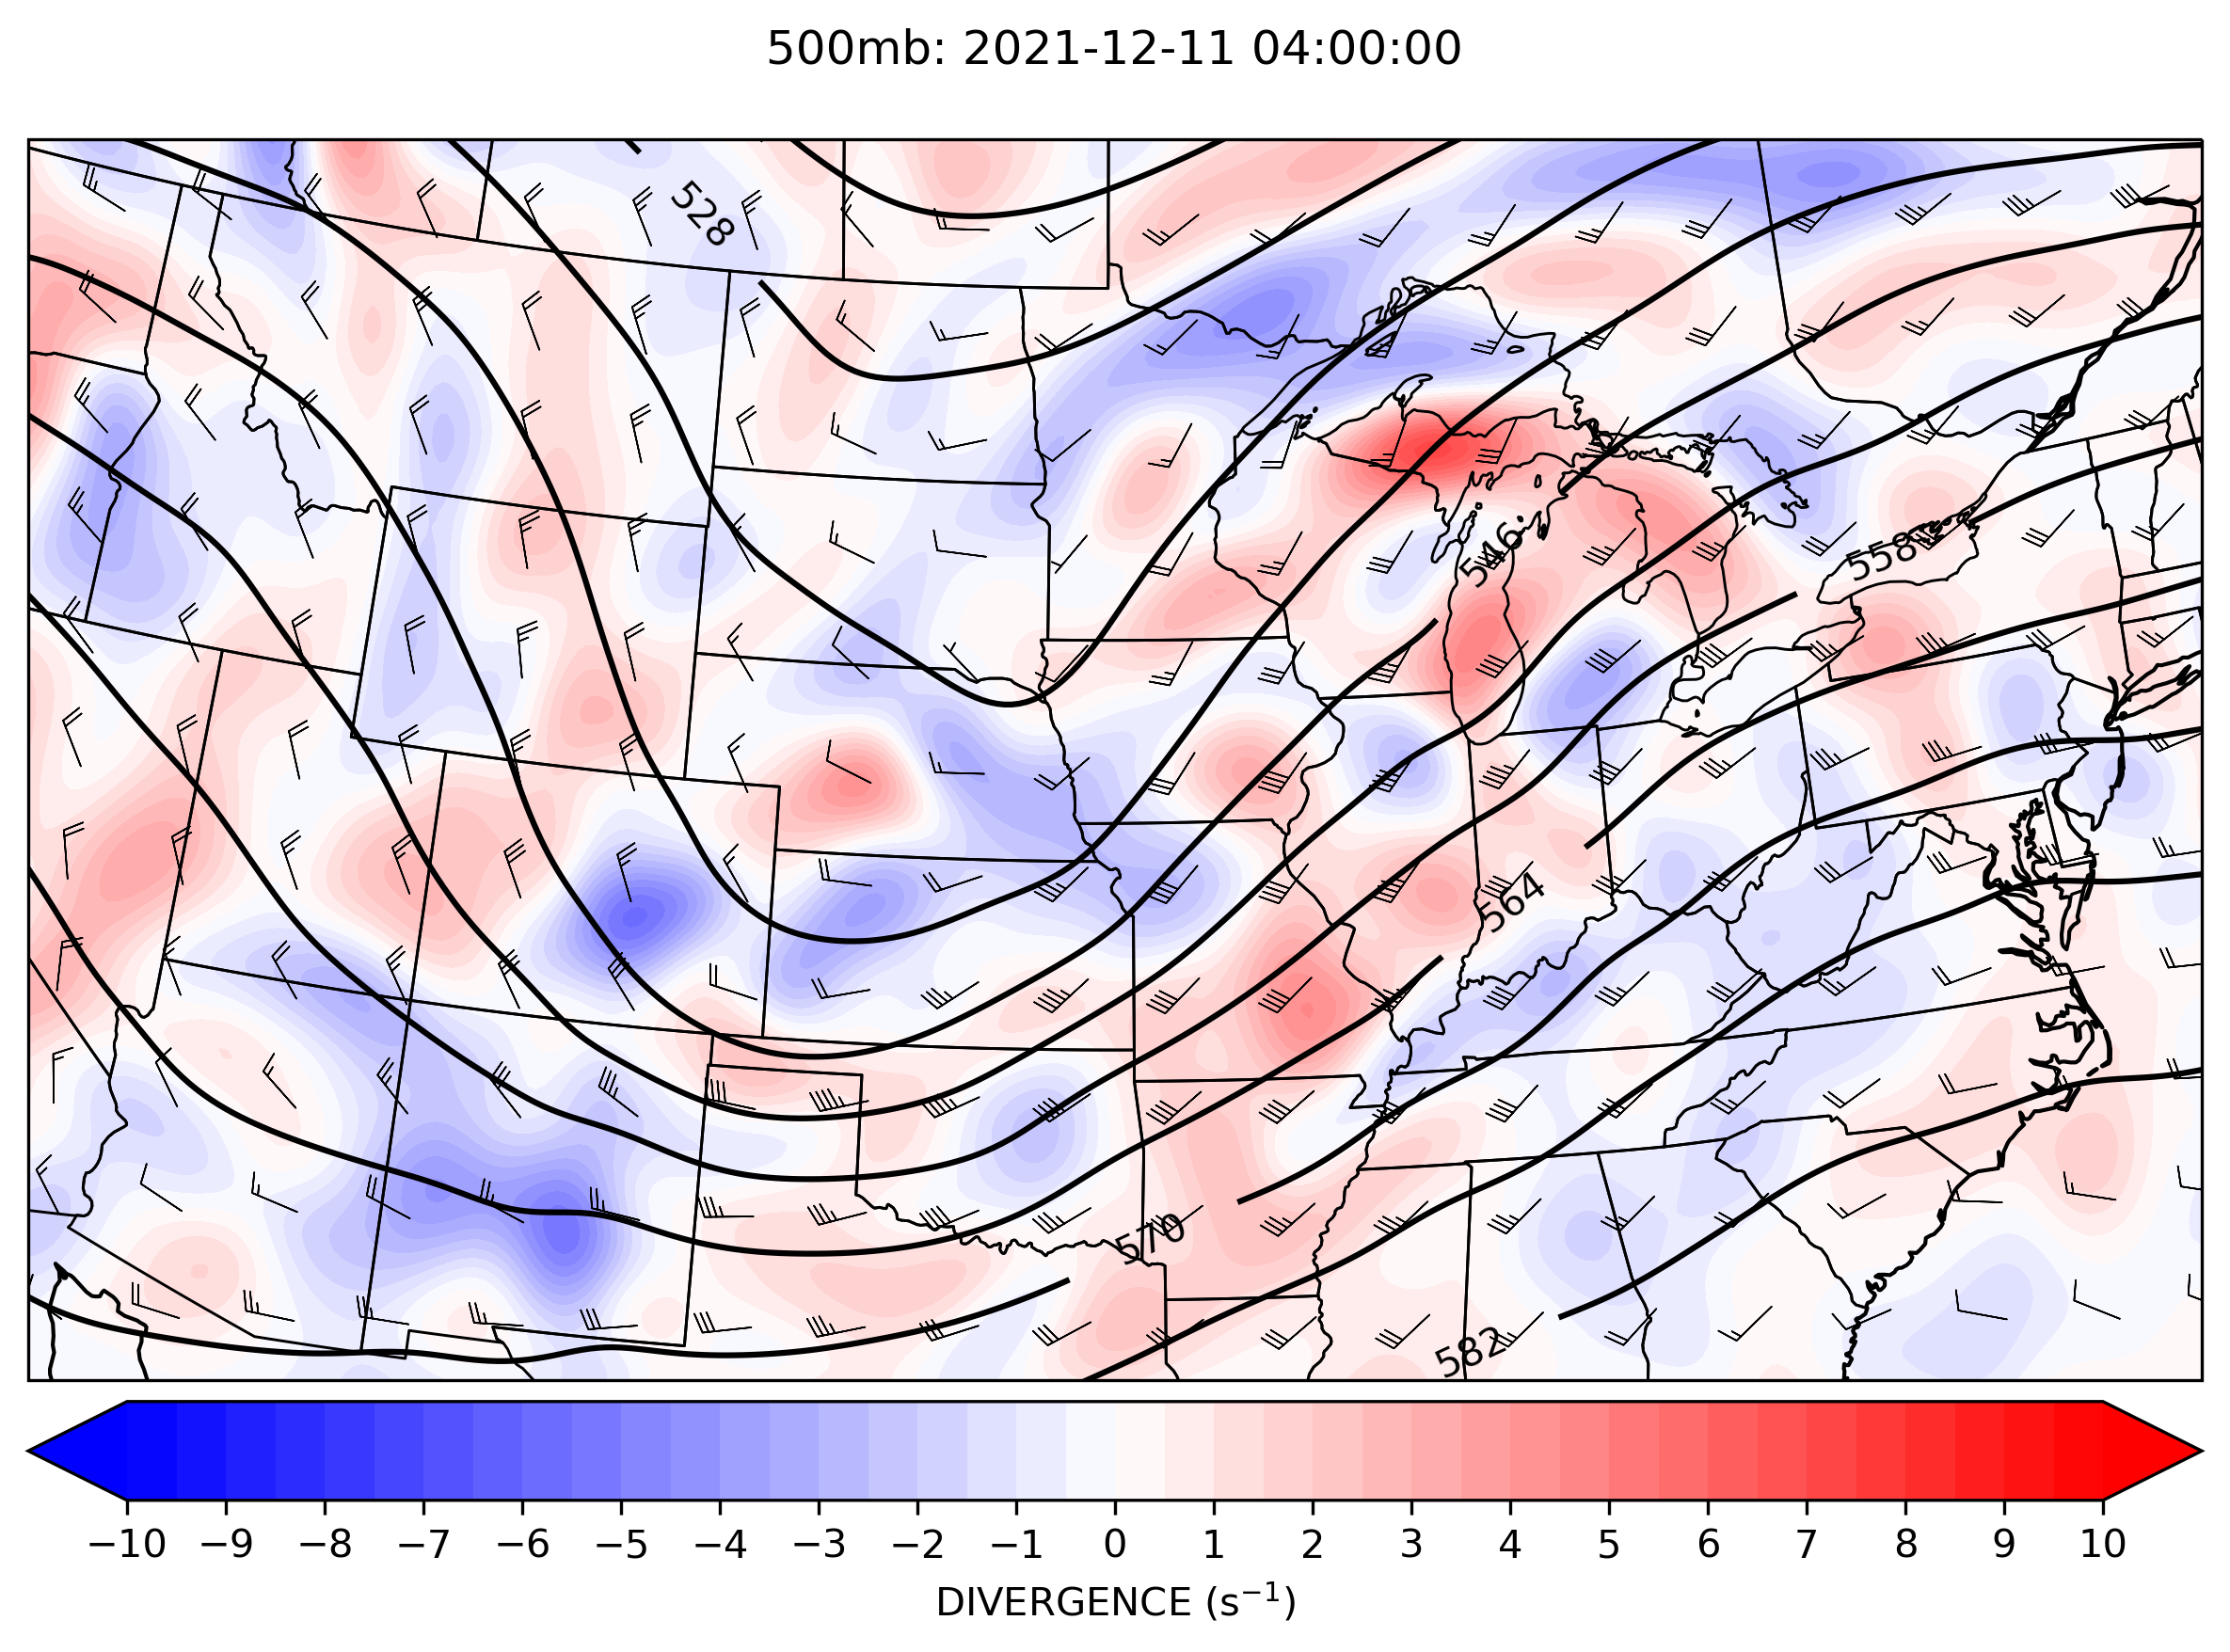

In [233]:
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cadv = ax.contourf(ds.lon,ds.lat,div_500*1E5,
                   np.arange(-10,10.1,0.5),cmap='bwr',extend='both',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cadv,location="bottom",ticks=np.arange(-10,11,1),pad=0.01)
cbar.set_label(r'DIVERGENCE $\rm{(s^{-1})}$')


cs = ax.contour(ds.lon,ds.lat,hght_500s,
                   np.arange(0,8000,60),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_500s[wind_slice].values,
            v_500s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())



ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'500mb: {dt}\n')
plt.savefig(f'500mb_div_{dt}.png',bbox_inches='tight')

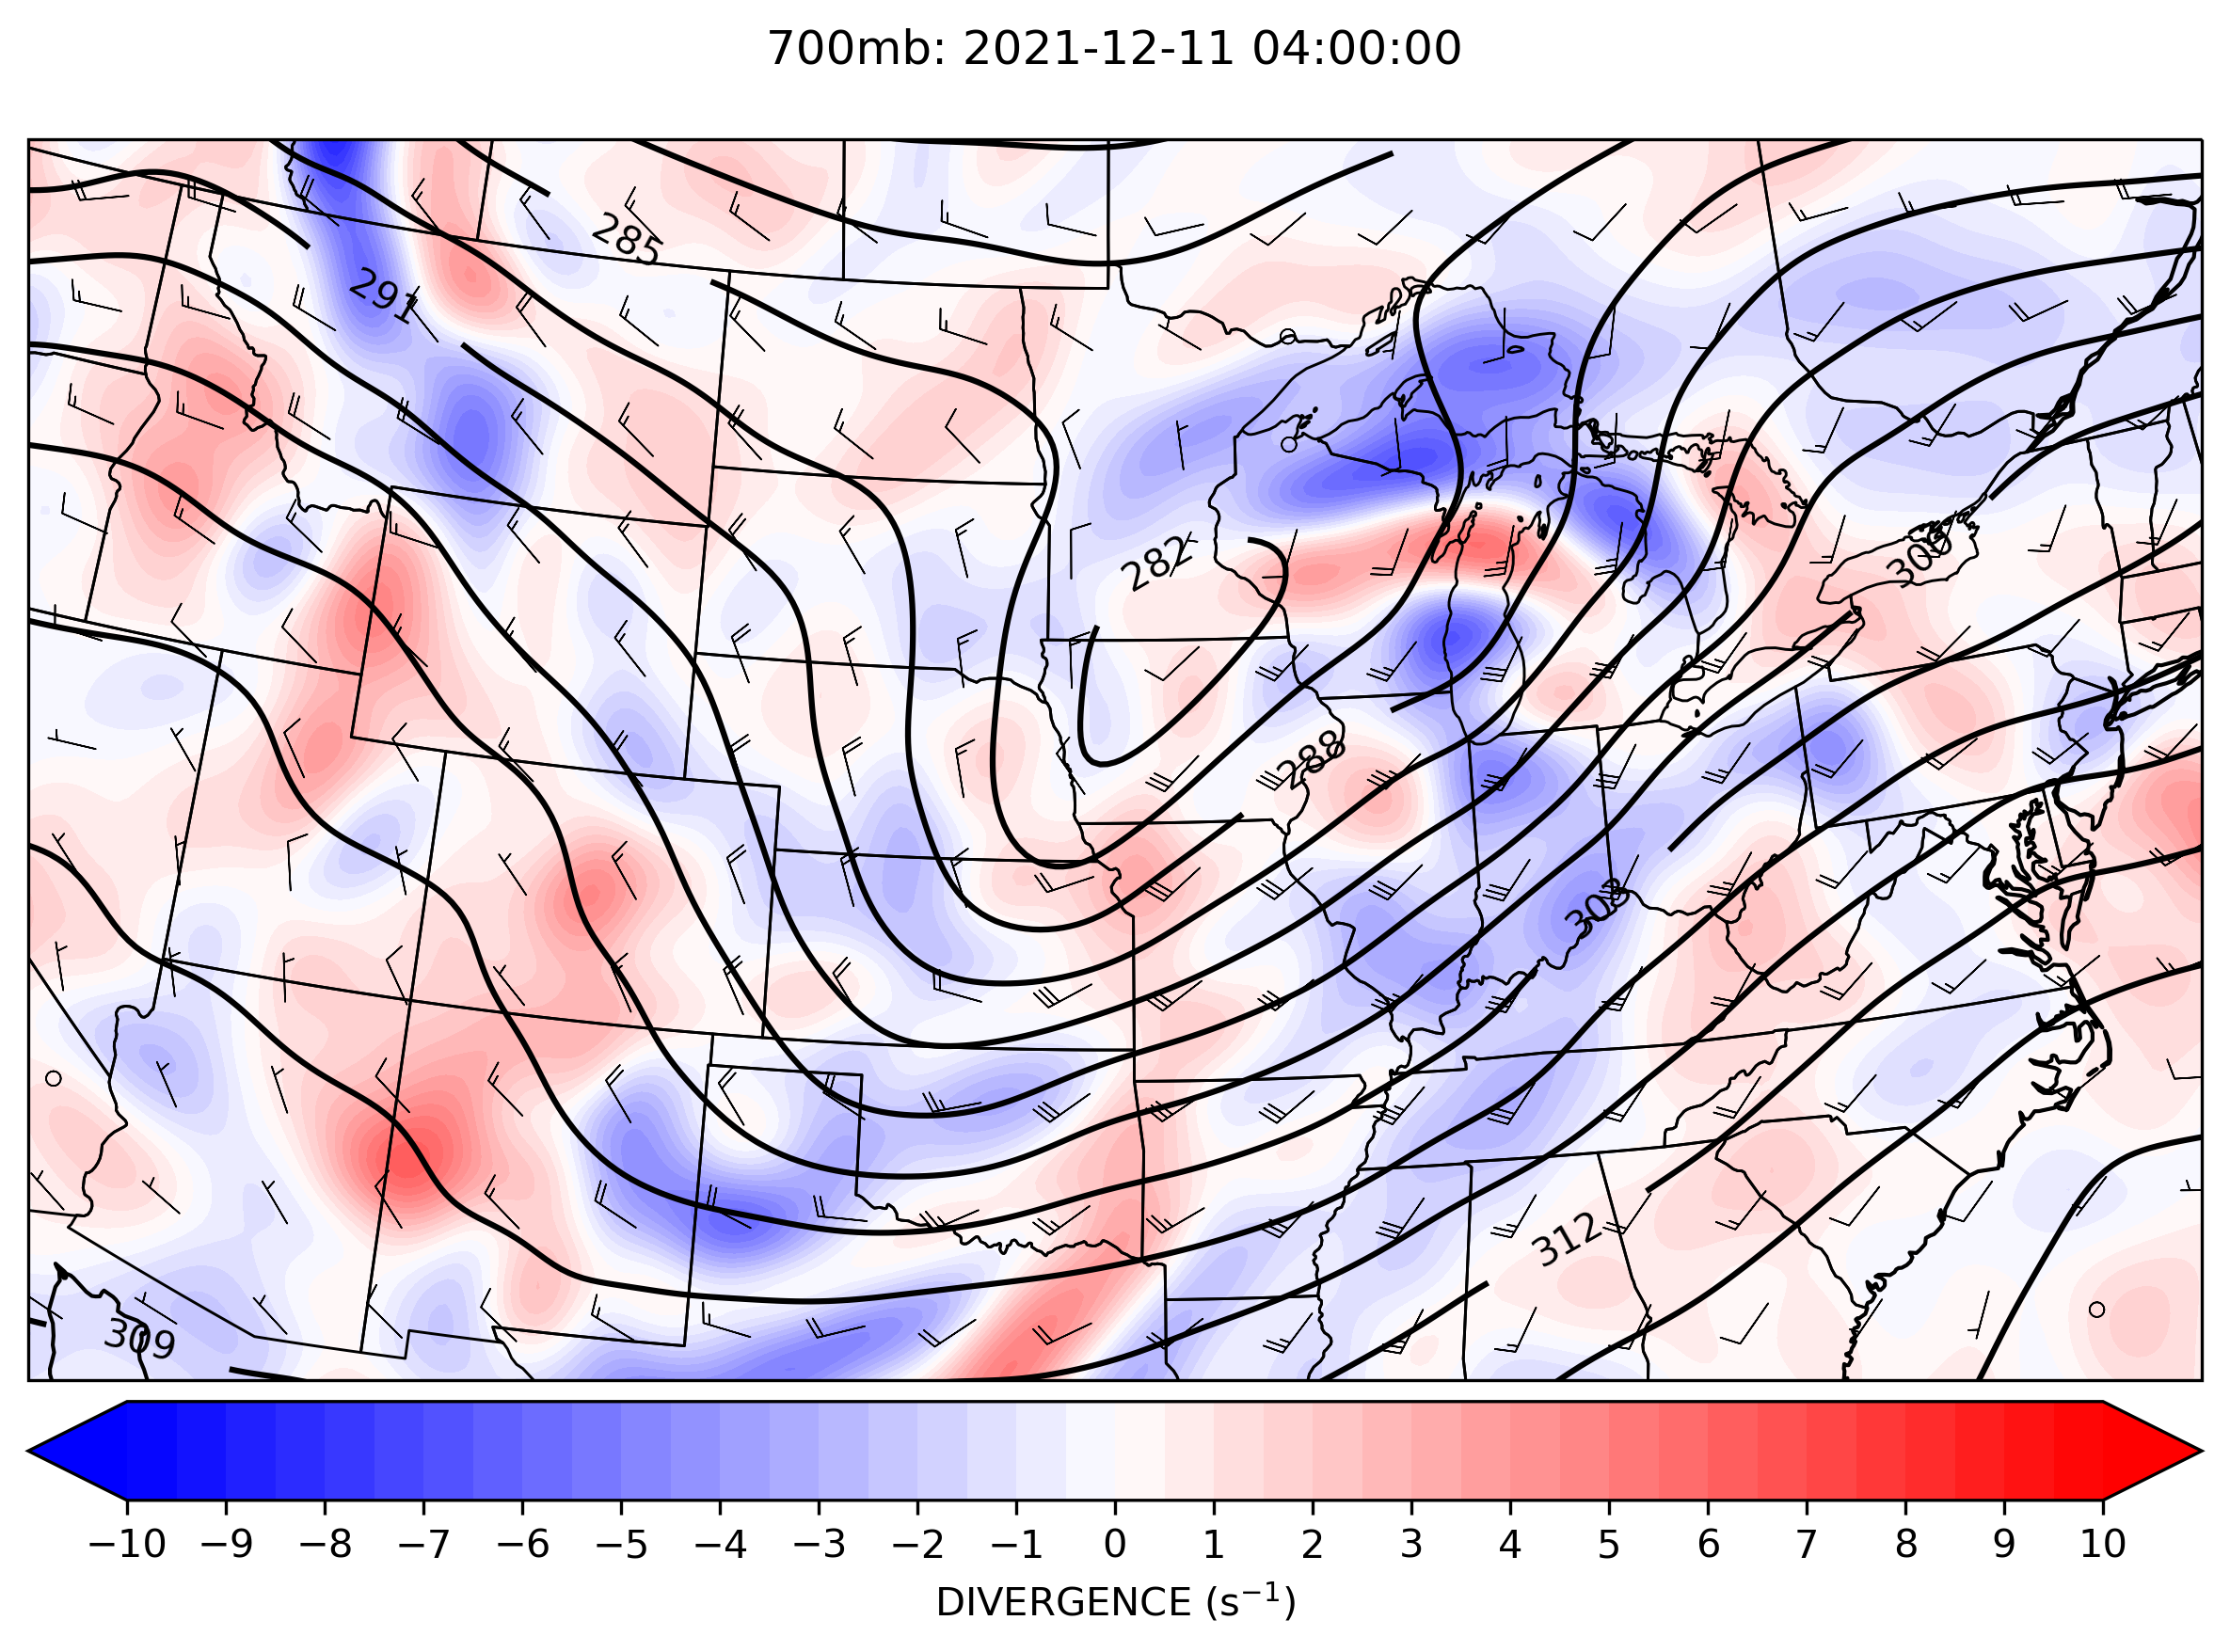

In [234]:
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cadv = ax.contourf(ds.lon,ds.lat,div_700*1E5,
                   np.arange(-10,10.1,0.5),cmap='bwr',extend='both',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cadv,location="bottom",ticks=np.arange(-10,11,1),pad=0.01)
cbar.set_label(r'DIVERGENCE $\rm{(s^{-1})}$')


cs = ax.contour(ds.lon,ds.lat,hght_700s,
                   np.arange(0,8000,30),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u_700s[wind_slice].values,
            v_700s[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())



ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'700mb: {dt}\n')
plt.savefig(f'700mb_div_{dt}.png',bbox_inches='tight')